<a href="https://colab.research.google.com/github/ClaudioLucioLopes/PrescriptiveAnalysis/blob/master/4_0_Localiza%C3%A7%C3%A3o_de_Lojas_e_CDs_Resposta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalação e módulos necessários

In [41]:
!pip install ortools
from ortools.linear_solver import pywraplp
import numpy as np
from itertools import product
from math import sqrt

#Organizando os dados

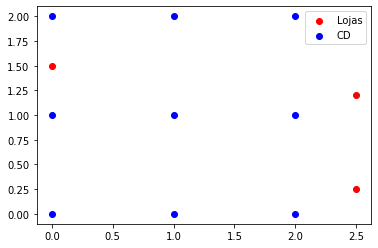

In [42]:

# Parametros
#localização de clientes

#Latitude e longitude das lojas
Lojas = [(0,1.5), (2.5,1.2),(2.5,0.25)]

#Latitude e longitude dos terrenos para construção dos Centros de Distribuição
CD = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2)]

#Valor em milhoes de reais
custo_galpao = [3,2,3,1.5,3,3,4,3,2]
custo_por_km = 1.1


# Vamos aplicar aqui uma a distância euclidiana, mas poderiamos pensar em outras distâncias(Manhattan,por exemplo)
def calcula_distancia(loc1, loc2):
    dx = loc1[0] - loc2[0]
    dy = loc1[1] - loc2[1]
    return sqrt(dx**2 + dy**2)

# Parametros iniciais: Número de lojas, Número de CD e possibilidades de atendimento lojas e CD
num_CD = len(CD)
num_Lojas = len(Lojas)
todas_possibilidades = list(product(range(num_Lojas), range(num_CD)))

# Calculando os custos de trajetos

custo_trajeto = {(c,l): custo_por_km*calcula_distancia(Lojas[c], CD[l]) for c, l in todas_possibilidades}


import matplotlib.pyplot as plt
x,y = zip(*Lojas)
plt.scatter(x, y,c='red',label='Lojas')
x,y = zip(*CD)
plt.scatter(x, y,c='blue',label='CD')
plt.legend()
plt.show()



In [43]:
# Criando modelo para seleção de locais
modelo_localizacao = pywraplp.Solver('Modelo ',pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

#Criando as variáveis de decisão
selecao_CD = {}
percentual_cobertura = {}

#Variavel que indica que um CD será selecionado ou não
for c in range(num_CD):
  selecao_CD[c] = modelo_localizacao.BoolVar(name='selecaoCD[%i]' % (c))


#Percentual da demanda da loja que será atendida pelo CD(se ele for construído) 
for l in range(num_Lojas):
  for c in range(num_CD):
      percentual_cobertura[l,c] = modelo_localizacao.NumVar(0,1,name='percentual_cobertura[%i,%i]' % (l,c))


#Restrições 
#Caso o CD seja selecionado teremos o percentual de cobertura que será coberto em cada loja
for l,c in todas_possibilidades:
  modelo_localizacao.Add(percentual_cobertura[l,c] <= selecao_CD[c])

#Devemos garantir que todas as lojas sem atendidas em 100% para pelos CD's
for l in range(num_Lojas):
 modelo_localizacao.Add(modelo_localizacao.Sum(percentual_cobertura[l,c] for c in range(num_CD)) == 1 )

# E quisessemos estipular um número mínimo de CD's para ser construído
modelo_localizacao.Add(modelo_localizacao.Sum(selecao_CD[c] for c in range(num_CD)) <= 3 )


#Criando a nossa função objetivo
Custo_Fixo_Ini =  modelo_localizacao.Sum([selecao_CD[c] * custo_galpao[c] for c in range(num_CD) ])    
Custo_Var =  modelo_localizacao.Sum([percentual_cobertura[l,c] * custo_trajeto[l,c] for c in range(num_CD) for l in range(num_Lojas)])    

#Atribuindo a maximização
objetivo = modelo_localizacao.Minimize(Custo_Fixo_Ini + Custo_Var)

#Executando o modelo

In [44]:
#Executando o modelo
modelo_localizacao.Solve()

print('Tempo: ', modelo_localizacao.WallTime(), 'ms')
print('Iterações: ', modelo_localizacao.iterations())

print(selecao_CD)

Tempo:  4333 ms
Iterações:  0
{0: selecaoCD[0], 1: selecaoCD[1], 2: selecaoCD[2], 3: selecaoCD[3], 4: selecaoCD[4], 5: selecaoCD[5], 6: selecaoCD[6], 7: selecaoCD[7], 8: selecaoCD[8]}


#Avaliando os resultados


In [45]:
print(modelo_localizacao.ExportModelAsLpFormat(False))

\ Generated by MPModelProtoExporter
\   Name             : Modelo 
\   Format           : Free
\   Constraints      : 31
\   Variables        : 36
\     Binary         : 9
\     Integer        : 0
\     Continuous     : 27
Minimize
 Obj: +3 selecaoCD[0] +2 selecaoCD[1] +3 selecaoCD[2] +1.5 selecaoCD[3] +3 selecaoCD[4] +3 selecaoCD[5] +4 selecaoCD[6] +3 selecaoCD[7] +2 selecaoCD[8] +1.65 percentual_cobertura[0,0] +0.55 percentual_cobertura[0,1] +0.55 percentual_cobertura[0,2] +1.98305 percentual_cobertura[0,3] +1.22984 percentual_cobertura[0,4] +1.22984 percentual_cobertura[0,5] +2.75 percentual_cobertura[0,6] +2.26771 percentual_cobertura[0,7] +2.26771 percentual_cobertura[0,8] +3.05039 percentual_cobertura[1,0] +2.75879 percentual_cobertura[1,1] +2.88737 percentual_cobertura[1,2] +2.11303 percentual_cobertura[1,3] +1.6646 percentual_cobertura[1,4] +1.87 percentual_cobertura[1,5] +1.43 percentual_cobertura[1,6] +0.592368 percentual_cobertura[1,7] +1.03774 percentual_cobertura[1,8] +2.7

In [46]:
print('Total: ', round(modelo_localizacao.Objective().Value(),2))

for c in range(num_CD):
    if (selecao_CD[c].solution_value() > 0):
        print(f"\n Construir o CD de posição {c+1 }.",CD[c])


# Avaliando os percentuais de cobertura.
for l in range(num_Lojas):
  for c in range(num_CD):
    if percentual_cobertura[l,c].solution_value() > 0:
        print(f"\n Loja {l + 1} receives {round(100*percentual_cobertura[l,c].solution_value(), 2)} % vindo do CD {c + 1} .")

Total:  6.85

 Construir o CD de posição 8. (2, 1)

 Loja 1 receives 100.0 % vindo do CD 8 .

 Loja 2 receives 100.0 % vindo do CD 8 .

 Loja 3 receives 100.0 % vindo do CD 8 .
